In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr, make_standup_agent, NN_params
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [7]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [8]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [64]:
#safe learning   
l = 0.5
step = 200000  # num of interval
episode_step = step
a = agent((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=0.00001, clipnorm=1.), Adam(lr=0.001, clipnorm=1.)
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mae"])
a.actor = make_standup_agent(a.actor, .01, env, verbose=False)
params_before = NN_params(a.actor)
# a.actor.load_weights('./saved_agent/self_trigger.h5')
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 102s 10ms/step - reward: -0.0091
6 episodes - episode_reward: -1.903 [-37.474, 9.931] - loss: 40.759 - mean_absolute_error: 3.317 - mean_q: 80.109

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -0.0105
1 episodes - episode_reward: -97.598 [-97.598, -97.598] - loss: 12.158 - mean_absolute_error: 1.713 - mean_q: -176.331

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 105s 10ms/step - reward: -0.0175
1 episodes - episode_reward: -174.980 [-174.980, -174.980] - loss: 16.664 - mean_absolute_error: 2.073 - mean_q: -1561.007

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 6913s 691ms/step - reward: -0.1740
15 episodes - episode_reward: -112.260 [-162.595, -66.523] - loss: 1634.452 - mean_absolute_error: 8.179 - mean_q: -2245.619

Interval 5 (40000 steps per

(49998,)


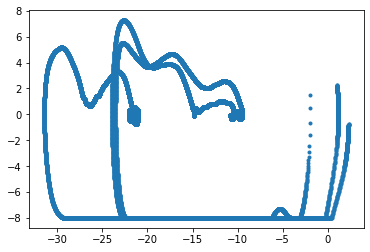

In [70]:
states = []
indices = np.array(range(1,49999))
print(indices.shape)
for e in a.memory.sample(len(indices), batch_idxs=indices):
    states.append(e.state0[0])
states = np.array(states)
plt.scatter(states[:,0], states[:,1], marker='.')
plt.show()
# 急に+∞のmemoryが増えちゃった = ρπの破滅

(array([  6.,  10.,  24.,  37.,  60., 105.,  80.,  24.,   6.,   2.]),
 array([-0.5069682 , -0.41397024, -0.32097229, -0.22797433, -0.13497638,
        -0.04197842,  0.05101954,  0.14401749,  0.23701545,  0.33001341,
         0.42301136]),
 <a list of 10 Patch objects>)

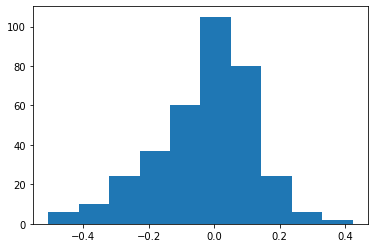

In [69]:
params_after = NN_params(a.actor)
params_dif = params_after - params_before
plt.hist(params_dif)

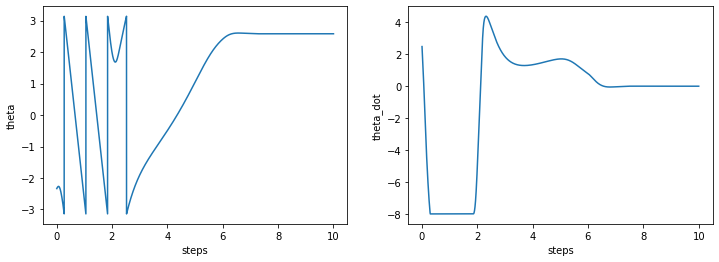

In [77]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
a.original_noise = False
env.reset()
high=np.array([np.pi,np.pi])
env.set_state(np.random.uniform(low=-high, high=high))
states = []
time_limit = 10
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

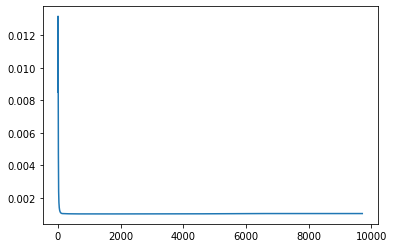

In [78]:
plt.plot(taus)

In [76]:
high=np.array([np.pi,np.pi])
np.random.uniform(low=-high, high=high)

array([-1.03456728, -2.52824338])